In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch import Tensor
from torchvision.utils import save_image
from tqdm import tqdm
import torchvision.datasets as datasets 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split
from CustomDataset import CustomDataset
from PIL import Image
import wandb


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = 3
#38804
Z_DIM = 1000
NUM_EPOCHS = 200
BATCH_SIZE = 32
LR_RATE = 3e-4
KL_COEFF = 0.0000025
PATH = "model.pt"

In [21]:
class VanillaVAE(nn.Module):
    def __init__(self,
                    in_channels: int,
                    latent_dim: int,
                    hidden_dims: list = None,
                    **kwargs) -> None:
            super(VanillaVAE, self).__init__()

            self.latent_dim = latent_dim

            modules = []
            if hidden_dims is None:
                hidden_dims = [32, 64, 128, 256, 512]

            # Build Encoder
            for h_dim in hidden_dims:
                modules.append(
                    nn.Sequential(
                        nn.Conv2d(in_channels, out_channels=h_dim,
                                kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(h_dim),
                        nn.LeakyReLU())
                )
                in_channels = h_dim

            self.encoder = nn.Sequential(*modules)
            self.fc_mu = nn.Linear(hidden_dims[-1]*42, latent_dim)
            self.fc_var = nn.Linear(hidden_dims[-1]*42, latent_dim)


            # Build Decoder
            modules = []

            self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 42)

            hidden_dims.reverse()

            for i in range(len(hidden_dims) - 1):
                modules.append(
                    nn.Sequential(
                        nn.ConvTranspose2d(hidden_dims[i],
                                        hidden_dims[i + 1],
                                        kernel_size=3,
                                        stride = 2,
                                        padding=1,
                                        output_padding=1),
                        nn.BatchNorm2d(hidden_dims[i + 1]),
                        nn.LeakyReLU())
                )



            self.decoder = nn.Sequential(*modules)

            self.final_layer = nn.Sequential(
                                nn.ConvTranspose2d(hidden_dims[-1],
                                                hidden_dims[-1],
                                                kernel_size=3,
                                                stride=2,
                                                padding=1,
                                                output_padding=1),
                                nn.BatchNorm2d(hidden_dims[-1]),
                                nn.LeakyReLU(),
                                nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                        kernel_size= 3, padding= 1),
                                nn.Tanh())

    def encode(self, input: Tensor) -> list[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 7, 6)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> list[Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                    *args) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        # kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        # kld_weight = 0.00025
        kld_weight = KL_COEFF
        # kld_weight = 0
        # print(recons.shape, input.shape)
        recons_loss =F.mse_loss(recons, input)


        kld_loss = kld_weight * torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        # loss = recons_loss + kld_loss
        return {'loss': (recons_loss, kld_loss), 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
            num_samples:int,
            current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [22]:
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": LR_RATE,
    "architecture": "VAE",
    "dataset": "CELEBA",
    "epochs": NUM_EPOCHS,
    }
)


kl_div,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconst_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kl_div,0.00073
reconst_loss,0.00456
total_loss,0.00529


In [23]:

batch_size = 32

data_length = 10#202599
dataset = CustomDataset("data/img_align_celeba", [(str(i).rjust(6, '0')+".jpg") for i in range(1,data_length+1)], transform=transforms.ToTensor())

# dataset_train, dataset_val = random_split(dataset, [int(data_length*0.8), data_length- int(data_length*0.8)])
dataset_train, dataset_val = dataset, dataset

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

0


In [24]:
# Define train function
def train(num_epochs, model, optimizer, loss_fn):
    # Start training
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} of {num_epochs}")
        loop = tqdm(enumerate(train_loader))
        epoch_loss = 0
        epoch_reconst_loss = 0
        epoch_kl_div = 0
        for i, x in loop:
            # Forward pass
            x = x.to(device) #.view(-1, INPUT_DIM)
            x_reconst, _, mu, sigma = model(x)

            # loss, formulas from https://www.youtube.com/watch?v=igP03FXZqgo&t=2182s
            reconst_loss, kl_div = loss_fn(x_reconst, x, mu, sigma)['loss']

            # Backprop and optimize
            # vec je weightovan kl_div
            loss = reconst_loss + kl_div
            
            
            #wandb.log({"examples": images}
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss = epoch_loss + loss.item()
            epoch_reconst_loss = epoch_reconst_loss + reconst_loss.item()
            epoch_kl_div = epoch_kl_div + kl_div.item()
            loop.set_postfix(loss=loss.item())
        
        wandb.log({"total_loss": loss,
                       "reconst_loss": reconst_loss,
                       "kl_div": kl_div})


        if(epoch%2 == 0):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                }, PATH)
            

# Initialize model, optimizer, loss
model = VanillaVAE(INPUT_DIM, Z_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = model.loss_function

train(NUM_EPOCHS, model, optimizer, model.loss_function)

Epoch 1 of 200


1it [00:01,  1.32s/it, loss=0.437]


Epoch 2 of 200


1it [00:01,  1.10s/it, loss=0.393]


Epoch 3 of 200


1it [00:01,  1.08s/it, loss=0.361]


Epoch 4 of 200


1it [00:01,  1.06s/it, loss=0.316]


Epoch 5 of 200


1it [00:01,  1.12s/it, loss=0.28]


Epoch 6 of 200


1it [00:01,  1.08s/it, loss=0.25]


Epoch 7 of 200


1it [00:01,  1.09s/it, loss=0.223]


Epoch 8 of 200


1it [00:01,  1.07s/it, loss=0.197]


Epoch 9 of 200


1it [00:01,  1.09s/it, loss=0.175]


Epoch 10 of 200


1it [00:01,  1.10s/it, loss=0.154]


Epoch 11 of 200


1it [00:01,  1.16s/it, loss=0.138]


Epoch 12 of 200


1it [00:01,  1.10s/it, loss=0.121]


Epoch 13 of 200


1it [00:01,  1.09s/it, loss=0.107]


Epoch 14 of 200


1it [00:01,  1.06s/it, loss=0.0956]


Epoch 15 of 200


1it [00:01,  1.12s/it, loss=0.0849]


Epoch 16 of 200


1it [00:01,  1.12s/it, loss=0.0768]


Epoch 17 of 200


1it [00:01,  1.13s/it, loss=0.0691]


Epoch 18 of 200


1it [00:01,  1.12s/it, loss=0.0636]


Epoch 19 of 200


1it [00:01,  1.17s/it, loss=0.0583]


Epoch 20 of 200


1it [00:01,  1.11s/it, loss=0.0538]


Epoch 21 of 200


1it [00:01,  1.21s/it, loss=0.0501]


Epoch 22 of 200


1it [00:01,  1.11s/it, loss=0.0468]


Epoch 23 of 200


1it [00:01,  1.10s/it, loss=0.0448]


Epoch 24 of 200


1it [00:01,  1.01s/it, loss=0.0419]


Epoch 25 of 200


1it [00:00,  1.00it/s, loss=0.0396]


Epoch 26 of 200


1it [00:00,  1.02it/s, loss=0.0387]


Epoch 27 of 200


1it [00:00,  1.02it/s, loss=0.0359]


Epoch 28 of 200


1it [00:01,  1.00s/it, loss=0.0345]


Epoch 29 of 200


1it [00:01,  1.00s/it, loss=0.0335]


Epoch 30 of 200


1it [00:01,  1.03s/it, loss=0.0319]


Epoch 31 of 200


1it [00:00,  1.01it/s, loss=0.0302]


Epoch 32 of 200


1it [00:01,  1.00s/it, loss=0.0297]


Epoch 33 of 200


1it [00:01,  1.02s/it, loss=0.028]


Epoch 34 of 200


1it [00:01,  1.01s/it, loss=0.0273]


Epoch 35 of 200


1it [00:01,  1.13s/it, loss=0.0263]


Epoch 36 of 200


1it [00:01,  1.04s/it, loss=0.0251]


Epoch 37 of 200


1it [00:00,  1.01it/s, loss=0.0248]


Epoch 38 of 200


1it [00:01,  1.01s/it, loss=0.0243]


Epoch 39 of 200


1it [00:01,  1.02s/it, loss=0.0229]


Epoch 40 of 200


1it [00:00,  1.01it/s, loss=0.0224]


Epoch 41 of 200


1it [00:00,  1.02it/s, loss=0.022]


Epoch 42 of 200


1it [00:01,  1.08s/it, loss=0.0219]


Epoch 43 of 200


1it [00:01,  1.03s/it, loss=0.0211]


Epoch 44 of 200


1it [00:01,  1.00s/it, loss=0.0202]


Epoch 45 of 200


1it [00:01,  1.03s/it, loss=0.02]


Epoch 46 of 200


1it [00:00,  1.02it/s, loss=0.0199]


Epoch 47 of 200


1it [00:01,  1.03s/it, loss=0.019]


Epoch 48 of 200


1it [00:01,  1.02s/it, loss=0.0185]


Epoch 49 of 200


1it [00:01,  1.02s/it, loss=0.0183]


Epoch 50 of 200


1it [00:01,  1.04s/it, loss=0.0183]


Epoch 51 of 200


1it [00:01,  1.06s/it, loss=0.0176]


Epoch 52 of 200


1it [00:01,  1.38s/it, loss=0.0178]


Epoch 53 of 200


1it [00:01,  1.03s/it, loss=0.0169]


Epoch 54 of 200


1it [00:01,  1.08s/it, loss=0.0169]


Epoch 55 of 200


1it [00:01,  1.06s/it, loss=0.0164]


Epoch 56 of 200


1it [00:01,  1.07s/it, loss=0.0165]


Epoch 57 of 200


1it [00:01,  1.16s/it, loss=0.0159]


Epoch 58 of 200


1it [00:01,  1.35s/it, loss=0.0161]


Epoch 59 of 200


1it [00:01,  1.12s/it, loss=0.0154]


Epoch 60 of 200


1it [00:01,  1.29s/it, loss=0.015]


Epoch 61 of 200


1it [00:01,  1.11s/it, loss=0.015]


Epoch 62 of 200


1it [00:01,  1.15s/it, loss=0.0148]


Epoch 63 of 200


1it [00:01,  1.15s/it, loss=0.0147]


Epoch 64 of 200


1it [00:01,  1.17s/it, loss=0.0145]


Epoch 65 of 200


1it [00:01,  1.18s/it, loss=0.0143]


Epoch 66 of 200


1it [00:01,  1.20s/it, loss=0.0141]


Epoch 67 of 200


1it [00:01,  1.14s/it, loss=0.014]


Epoch 68 of 200


1it [00:01,  1.11s/it, loss=0.0136]


Epoch 69 of 200


1it [00:01,  1.19s/it, loss=0.0136]


Epoch 70 of 200


1it [00:01,  1.08s/it, loss=0.0133]


Epoch 71 of 200


1it [00:01,  1.09s/it, loss=0.0131]


Epoch 72 of 200


1it [00:01,  1.09s/it, loss=0.0128]


Epoch 73 of 200


1it [00:01,  1.08s/it, loss=0.0129]


Epoch 74 of 200


1it [00:01,  1.10s/it, loss=0.0126]


Epoch 75 of 200


1it [00:01,  1.09s/it, loss=0.0125]


Epoch 76 of 200


1it [00:01,  1.14s/it, loss=0.0123]


Epoch 77 of 200


1it [00:01,  1.11s/it, loss=0.0121]


Epoch 78 of 200


1it [00:01,  1.08s/it, loss=0.0123]


Epoch 79 of 200


1it [00:01,  1.10s/it, loss=0.0119]


Epoch 80 of 200


1it [00:01,  1.08s/it, loss=0.0117]


Epoch 81 of 200


1it [00:01,  1.09s/it, loss=0.0117]


Epoch 82 of 200


1it [00:01,  1.16s/it, loss=0.0116]


Epoch 83 of 200


1it [00:01,  1.13s/it, loss=0.0115]


Epoch 84 of 200


1it [00:01,  1.09s/it, loss=0.0115]


Epoch 85 of 200


1it [00:01,  1.27s/it, loss=0.0113]


Epoch 86 of 200


1it [00:01,  1.13s/it, loss=0.011]


Epoch 87 of 200


1it [00:01,  1.26s/it, loss=0.0111]


Epoch 88 of 200


1it [00:01,  1.17s/it, loss=0.0107]


Epoch 89 of 200


1it [00:01,  1.11s/it, loss=0.0107]


Epoch 90 of 200


1it [00:01,  1.14s/it, loss=0.0106]


Epoch 91 of 200


1it [00:01,  1.11s/it, loss=0.0106]


Epoch 92 of 200


1it [00:01,  1.16s/it, loss=0.0102]


Epoch 93 of 200


1it [00:01,  1.12s/it, loss=0.0104]


Epoch 94 of 200


1it [00:01,  1.24s/it, loss=0.0104]


Epoch 95 of 200


1it [00:01,  1.11s/it, loss=0.0101]


Epoch 96 of 200


1it [00:01,  1.12s/it, loss=0.0101]


Epoch 97 of 200


1it [00:01,  1.10s/it, loss=0.00997]


Epoch 98 of 200


1it [00:01,  1.15s/it, loss=0.00979]


Epoch 99 of 200


1it [00:01,  1.13s/it, loss=0.00963]


Epoch 100 of 200


1it [00:01,  1.18s/it, loss=0.00968]


Epoch 101 of 200


1it [00:01,  1.14s/it, loss=0.0095]


Epoch 102 of 200


1it [00:01,  1.14s/it, loss=0.00954]


Epoch 103 of 200


1it [00:01,  1.09s/it, loss=0.00941]


Epoch 104 of 200


1it [00:01,  1.01s/it, loss=0.00926]


Epoch 105 of 200


1it [00:00,  1.00it/s, loss=0.00919]


Epoch 106 of 200


1it [00:01,  1.03s/it, loss=0.00888]


Epoch 107 of 200


1it [00:01,  1.00s/it, loss=0.00913]


Epoch 108 of 200


1it [00:01,  1.03s/it, loss=0.00891]


Epoch 109 of 200


1it [00:01,  1.01s/it, loss=0.00881]


Epoch 110 of 200


1it [00:01,  1.01s/it, loss=0.00892]


Epoch 111 of 200


1it [00:01,  1.00s/it, loss=0.00864]


Epoch 112 of 200


1it [00:01,  1.03s/it, loss=0.00859]


Epoch 113 of 200


1it [00:01,  1.12s/it, loss=0.00871]


Epoch 114 of 200


1it [00:01,  1.02s/it, loss=0.00844]


Epoch 115 of 200


1it [00:01,  1.02s/it, loss=0.00858]


Epoch 116 of 200


1it [00:01,  1.01s/it, loss=0.00841]


Epoch 117 of 200


1it [00:01,  1.02s/it, loss=0.00842]


Epoch 118 of 200


1it [00:01,  1.04s/it, loss=0.00842]


Epoch 119 of 200


1it [00:00,  1.01it/s, loss=0.00826]


Epoch 120 of 200


1it [00:00,  1.00it/s, loss=0.00826]


Epoch 121 of 200


1it [00:01,  1.01s/it, loss=0.00805]


Epoch 122 of 200


1it [00:01,  1.02s/it, loss=0.00823]


Epoch 123 of 200


1it [00:01,  1.01s/it, loss=0.00809]


Epoch 124 of 200


1it [00:01,  1.01s/it, loss=0.00795]


Epoch 125 of 200


1it [00:01,  1.12s/it, loss=0.00817]


Epoch 126 of 200


1it [00:01,  1.00s/it, loss=0.00786]


Epoch 127 of 200


1it [00:01,  1.02s/it, loss=0.0079]


Epoch 128 of 200


1it [00:01,  1.02s/it, loss=0.00796]


Epoch 129 of 200


1it [00:01,  1.01s/it, loss=0.00789]


Epoch 130 of 200


1it [00:01,  1.07s/it, loss=0.00792]


Epoch 131 of 200


1it [00:01,  1.06s/it, loss=0.00779]


Epoch 132 of 200


1it [00:01,  1.10s/it, loss=0.00789]


Epoch 133 of 200


1it [00:01,  1.02s/it, loss=0.00756]


Epoch 134 of 200


1it [00:01,  1.00s/it, loss=0.0079]


Epoch 135 of 200


1it [00:01,  1.08s/it, loss=0.00755]


Epoch 136 of 200


1it [00:01,  1.07s/it, loss=0.00773]


Epoch 137 of 200


1it [00:00,  1.02it/s, loss=0.00745]


Epoch 138 of 200


1it [00:00,  1.01it/s, loss=0.00746]


Epoch 139 of 200


1it [00:00,  1.01it/s, loss=0.00752]


Epoch 140 of 200


1it [00:00,  1.02it/s, loss=0.00731]


Epoch 141 of 200


1it [00:00,  1.01it/s, loss=0.00739]


Epoch 142 of 200


1it [00:00,  1.02it/s, loss=0.00733]


Epoch 143 of 200


1it [00:00,  1.02it/s, loss=0.00731]


Epoch 144 of 200


1it [00:00,  1.01it/s, loss=0.00733]


Epoch 145 of 200


1it [00:00,  1.02it/s, loss=0.00718]


Epoch 146 of 200


1it [00:00,  1.02it/s, loss=0.00705]


Epoch 147 of 200


1it [00:00,  1.02it/s, loss=0.00703]


Epoch 148 of 200


1it [00:00,  1.01it/s, loss=0.00698]


Epoch 149 of 200


1it [00:00,  1.01it/s, loss=0.0069]


Epoch 150 of 200


1it [00:01,  1.00s/it, loss=0.00709]


Epoch 151 of 200


1it [00:01,  1.02s/it, loss=0.00678]


Epoch 152 of 200


1it [00:01,  1.14s/it, loss=0.00695]


Epoch 153 of 200


1it [00:00,  1.03it/s, loss=0.00675]


Epoch 154 of 200


1it [00:00,  1.04it/s, loss=0.00683]


Epoch 155 of 200


1it [00:00,  1.03it/s, loss=0.00685]


Epoch 156 of 200


1it [00:00,  1.02it/s, loss=0.00667]


Epoch 157 of 200


1it [00:00,  1.01it/s, loss=0.00683]


Epoch 158 of 200


1it [00:01,  1.00s/it, loss=0.00686]


Epoch 159 of 200


1it [00:00,  1.01it/s, loss=0.00667]


Epoch 160 of 200


1it [00:00,  1.01it/s, loss=0.00662]


Epoch 161 of 200


1it [00:00,  1.00it/s, loss=0.00654]


Epoch 162 of 200


1it [00:01,  1.02s/it, loss=0.00661]


Epoch 163 of 200


1it [00:01,  1.02s/it, loss=0.00653]


Epoch 164 of 200


1it [00:01,  1.04s/it, loss=0.00664]


Epoch 165 of 200


1it [00:01,  1.02s/it, loss=0.00652]


Epoch 166 of 200


1it [00:01,  1.00s/it, loss=0.00635]


Epoch 167 of 200


1it [00:01,  1.04s/it, loss=0.00638]


Epoch 168 of 200


1it [00:00,  1.00it/s, loss=0.00637]


Epoch 169 of 200


1it [00:01,  1.04s/it, loss=0.00633]


Epoch 170 of 200


1it [00:01,  1.03s/it, loss=0.00625]


Epoch 171 of 200


1it [00:01,  1.01s/it, loss=0.0062]


Epoch 172 of 200


1it [00:01,  1.01s/it, loss=0.00625]


Epoch 173 of 200


1it [00:00,  1.02it/s, loss=0.00615]


Epoch 174 of 200


1it [00:00,  1.01it/s, loss=0.00616]


Epoch 175 of 200


1it [00:00,  1.01it/s, loss=0.00619]


Epoch 176 of 200


1it [00:01,  1.02s/it, loss=0.00606]


Epoch 177 of 200


1it [00:00,  1.02it/s, loss=0.00613]


Epoch 178 of 200


1it [00:01,  1.01s/it, loss=0.00619]


Epoch 179 of 200


1it [00:01,  1.00s/it, loss=0.00597]


Epoch 180 of 200


1it [00:01,  1.03s/it, loss=0.00611]


Epoch 181 of 200


1it [00:01,  1.03s/it, loss=0.00598]


Epoch 182 of 200


1it [00:01,  1.06s/it, loss=0.00602]


Epoch 183 of 200


1it [00:01,  1.01s/it, loss=0.00594]


Epoch 184 of 200


1it [00:01,  1.30s/it, loss=0.00612]


Epoch 185 of 200


1it [00:01,  1.61s/it, loss=0.00602]


Epoch 186 of 200


1it [00:01,  1.36s/it, loss=0.00605]


Epoch 187 of 200


1it [00:01,  1.35s/it, loss=0.00598]


Epoch 188 of 200


1it [00:01,  1.47s/it, loss=0.00579]


Epoch 189 of 200


1it [00:01,  1.24s/it, loss=0.00598]


Epoch 190 of 200


1it [00:01,  1.21s/it, loss=0.00583]


Epoch 191 of 200


1it [00:01,  1.12s/it, loss=0.00578]


Epoch 192 of 200


1it [00:01,  1.08s/it, loss=0.00583]


Epoch 193 of 200


1it [00:01,  1.18s/it, loss=0.00581]


Epoch 194 of 200


1it [00:01,  1.00s/it, loss=0.00568]


Epoch 195 of 200


1it [00:01,  1.01s/it, loss=0.00577]


Epoch 196 of 200


1it [00:01,  1.05s/it, loss=0.00578]


Epoch 197 of 200


1it [00:01,  1.05s/it, loss=0.00563]


Epoch 198 of 200


1it [00:01,  1.08s/it, loss=0.00561]


Epoch 199 of 200


1it [00:01,  1.20s/it, loss=0.00561]


Epoch 200 of 200


1it [00:01,  1.12s/it, loss=0.0057]


In [25]:
# Run training


In [26]:
def validation(model, loss_fn):
    model.eval()
    with torch.no_grad():
        loss = 0
        for i, x in enumerate(validation_loader):
            x = x.to(device).view(-1, INPUT_DIM)
            x_reconst, _, mu, sigma = model(x)
            reconst_loss = loss_fn(x_reconst, x, mu, sigma)
            kl_div = - torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            loss = loss + (reconst_loss + kl_div).item()
        print("Validation loss: ", loss/len(validation_loader.dataset))


In [27]:
# validation(model, model.loss_function)

In [31]:
def test_inference():

    image = Image.open("data/img_align_celeba/000004.jpg")
    transform=transforms.ToTensor()

    encodings = []
    with torch.no_grad():
        mu, sigma = model.encode(transform(image).unsqueeze(0))
        encodings.append((mu, sigma))

    mu, sigma = encodings[0]

    epsilon = torch.randn_like(sigma)
    z = mu + sigma * epsilon
    out = model.decode(z)
    out = out.view(-1, 3, 224, 192)
    save_image(out, f"generated_ex.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


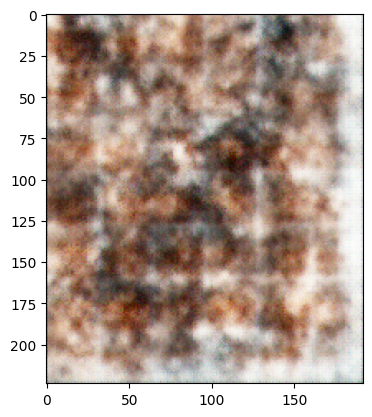

In [29]:
def generate_new():
    import numpy as np
    import matplotlib.pyplot as plt
    z = torch.randn(1, Z_DIM).to(device)
    out = model.decode(z)
    out = out.view(-1, 3, 224, 192)
    #save_image(out, f"generated_ex.png")
    # change to PIL and plot
    out = out.cpu().detach().numpy()
    out = np.transpose(out, (0, 2, 3, 1))
    plt.imshow(out[0])

generate_new()


In [32]:
test_inference()